# Coding Assignment 1: Image Classification
- In this assignment you have to train image classification model with your own data


In [1]:
import torch
torch.cuda.set_device('cuda:1')

In [2]:
!pip install -Uqq fastbook
!pip install -q jmd_imagescraper

from fastai.vision.all import *
from fastai.vision.widgets import *
from fastbook import *
from jmd_imagescraper.core import duckduckgo_search
import random
import shutil
import os

/opt/conda/lib/python3.8/site-packages/fastbook/__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


## Problem 1: Collect Data (30 pts)
- You have to select 4 image categories of your own choice

In [4]:
def configure_image_categories():
  '''
  input: None
  output: List of strings that contains 4 classes

  example: image_keywords = ['football', 'basketball', 'baseball', 'volleyball']
  '''
  # TODO: Complete the function
  image_keywords = ['football_match', 'basketball_match', 'baseball_match', 'volleyball_match']
  return image_keywords



## Image Crawling
- Following code will automatically crawl the code


In [5]:
NUM_IMG = 100

image_types = configure_image_categories()
assert len(image_types)==4, "The length of image types has to be 4"
assert all( isinstance(typ, str) for typ in image_types), "Every element of image_types has to be string"

# Delete the previous images
!rm -rf images 

img_dir = Path('images')
train_dir = img_dir / 'train'
valid_dir = img_dir / 'valid'
for typ in image_types:
  duckduckgo_search(img_dir, typ, typ, max_results=NUM_IMG)
  typ_dir = img_dir / typ
  img_files = get_image_files(typ_dir)
  failed = verify_images(img_files)
  failed.map(Path.unlink)
  img_files 

Duckduckgo search: football_match


Duckduckgo search: basketball_match


Duckduckgo search: baseball_match


Duckduckgo search: volleyball_match


### Split train and valid by directory
- Do NOT change this cell
- After running it, it will automatically split train and valid to ratio of 8:2
  - Training data will be located `images/train`
  - Validation data will be locatd `images/valid`

In [6]:
random.seed(0)
valid_indices = random.sample(range(NUM_IMG), NUM_IMG//5)

for typ in image_types:
  typ_dir = img_dir / typ
  if not typ_dir.exists():
    continue
  train_dir = img_dir / 'train' / typ
  valid_dir = img_dir / 'valid' / typ
  train_dir.mkdir(parents=True, exist_ok=True)
  valid_dir.mkdir(parents=True, exist_ok=True)
  img_files = get_image_files(typ_dir)
  valid_imgs = img_files[valid_indices]
  for fn in img_files[valid_indices]:
    shutil.move(fn, valid_dir/fn.name)
  img_files = get_image_files(typ_dir)
  for fn in img_files:
    shutil.move(fn, train_dir/fn.name)
  assert len(get_image_files(typ_dir)) == 0, f"There are still remaining files in {typ_dir}"
  os.rmdir(typ_dir)


## Problem 2: Report the first training result (20 pts)
- Use the default settings of fastai
    - without data augmentation

### DataBlock
Class that can feed data in a right format to fastai model.
* *blocks*: type of input/labels. 
  * *(ImageBlock, CategoryBlock)* means that input is image and label is categorical value
* *get_items*: a function to load item from storage. 
  * *get_image_files* is a fastai function that get lists of image files in a given directory
* *splitter*: a function to split train and validation
  * *RandomSplitter* splits dataset in random.
* *get_y*: a function to get label 
  * *parent_label* means to use name of parent directory of item as the label
* *item_tfms*: item transformation. How to transform the loaded item before feeding it to a neural network model
  * *Resize* is to resize entire image into square of certain size. 

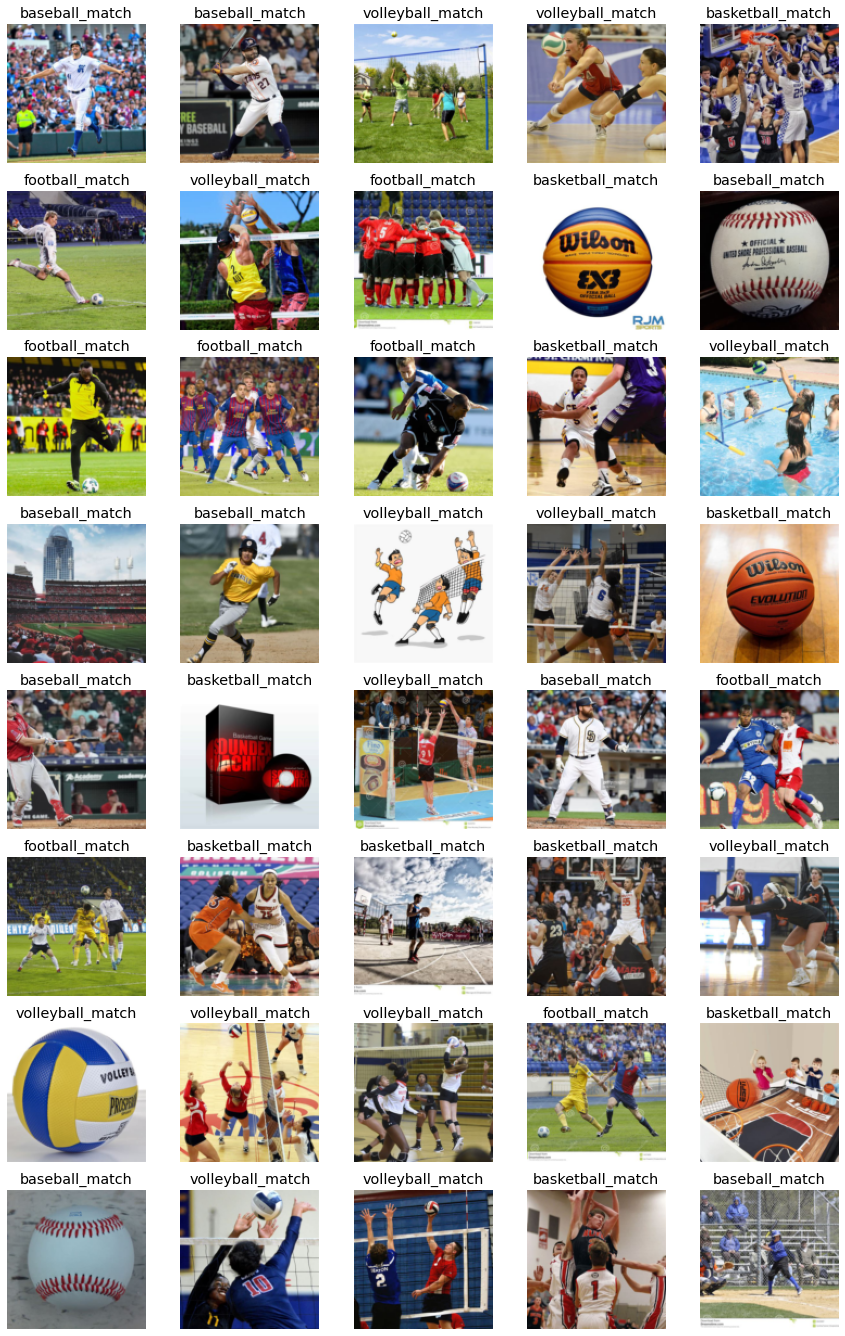

In [8]:
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = images.dataloaders(img_dir)
dls.train.show_batch(max_n=40, ncols=5, unique=False)

In [9]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(20) 

epoch,train_loss,valid_loss,error_rate,time
0,2.207017,2.748105,0.650000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.390441,1.659421,0.575000,00:01
1,1.193279,1.260957,0.500000,00:01
2,1.027684,1.104415,0.425000,00:01
3,0.860500,1.035494,0.412500,00:01
4,0.715782,1.003461,0.362500,00:01
5,0.593789,0.990678,0.337500,00:01
6,0.495602,1.024434,0.337500,00:01
7,0.415274,1.052447,0.312500,00:01
8,0.352772,1.078298,0.337500,00:01
9,0.303328,1.090296,0.325000,00:01


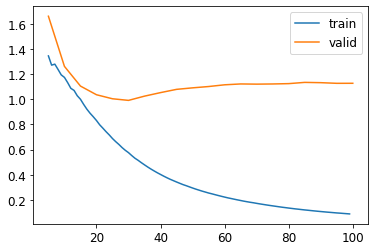

In [10]:
learn.recorder.plot_loss()

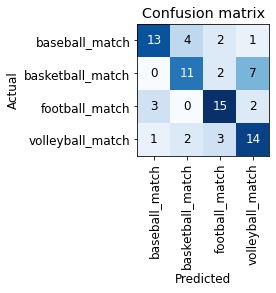

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

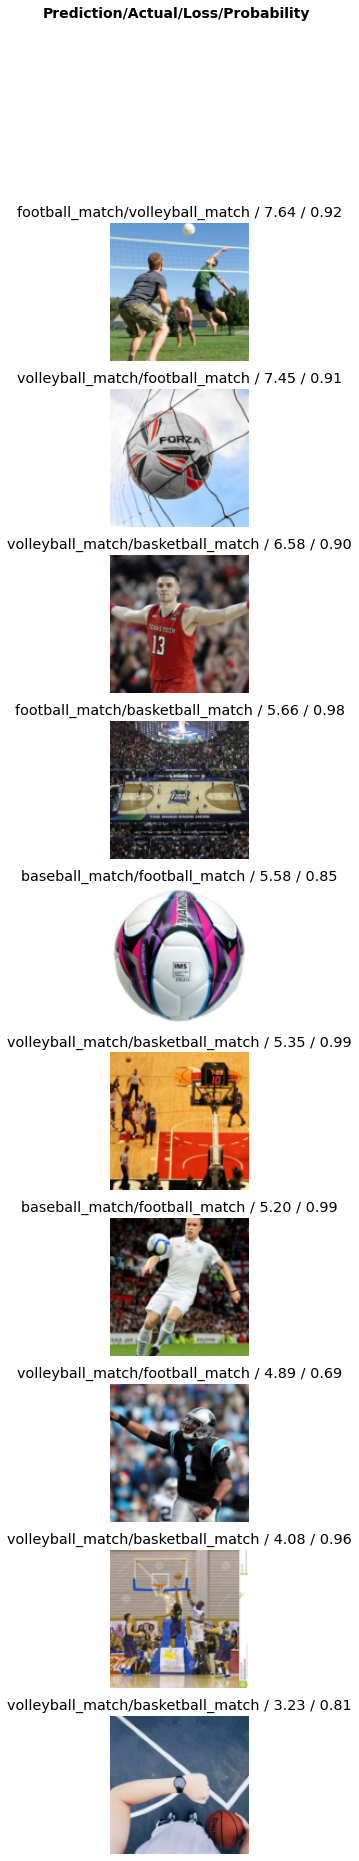

In [13]:
interp.plot_top_losses(10, ncols=1)

## Problem 3: Try other settings 
- Try Data Augmentation with `DataBlock`
- Try various learning rates

In [ ]:
dir(interp)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__stored_args__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'confusion_matrix',
 'decoded',
 'dl',
 'from_learner',
 'inputs',
 'losses',
 'most_confused',
 'plot_confusion_matrix',
 'plot_top_losses',
 'preds',
 'print_classification_report',
 'targs',
 'top_losses',
 'vocab']

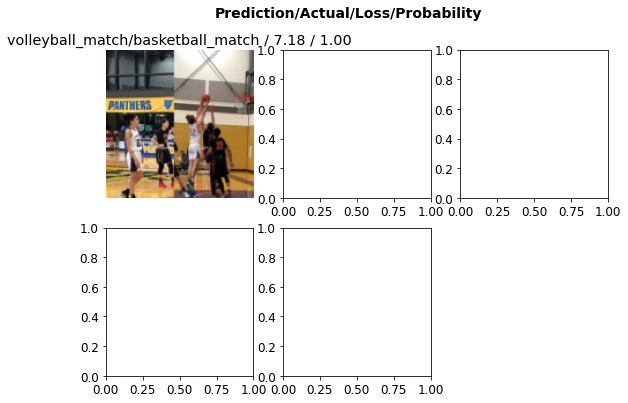

In [11]:
interp.plot_top_losses(5)

In [15]:
from jmd_imagescraper.imagecleaner import display_image_cleaner

display_image_cleaner('images/valid')

HTML(value='<h2>No images left to display in this folder.</h2>', layout=Layout(visibility='hidden'))

GridBox(children=(VBox(children=(Image(value=b'', layout="Layout(width='150px')"), Button(description='Delete'…